In [1]:
#import all the necessary packages
import numpy as np #for numerical array data
import pandas as pd #for tabular data
import matplotlib.pyplot as plt #for plotting purposes

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import importlib as imp
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import cvxpy as cp
all_data = pd.read_csv("Data_Oct2018.csv")
all_data['Date'] = pd.to_datetime(all_data['Date'])

In [3]:
all_data.head(5)

,Date,World Equities,US Treasuries,Bond Risk Premium,Inflation Protection,Currency Protection,US Equities,Real Estate,Commodities,Corp Bonds
0,1985-01-01,0.028511,0.031500,0.006408,-0.016265,0.030292,0.081301,0.056605,0.021351,0.048963
1,1985-02-01,-0.009204,-0.044692,0.057381,0.006362,0.010258,0.030075,0.016448,-0.015217,-0.042029
2,1985-03-01,0.075134,0.028719,-0.024396,-0.002848,-0.020739,-0.007299,-0.006716,0.037171,0.032666
3,1985-04-01,-0.002459,0.023084,-0.004869,0.003089,0.008187,-0.012255,0.000906,-0.035116,0.037125
4,1985-05-01,0.040245,0.086780,-0.044417,0.004077,-0.002219,0.064516,0.027241,0.004351,0.104199


In [4]:
def data_time_periods(data, dateName):
    '''data_time_periods figures out if the data is daily, weekly, monthly, etc
    INPUTS:
        data: pandas df, has a date column in it with column name dateName
        dateName: string, name of column to be analysed
    '''
    secondToLast = data[dateName].tail(2)[:-1]
    last = data[dateName].tail(1)
    duration = (last.values - secondToLast.values).astype('timedelta64[D]') / np.timedelta64(1, 'D')
    print("duration is",duration)
    duration = duration[0]
    print("duration is",duration)
    if (duration > 200):
        return 'yearly'
    elif(duration > 20):
        return 'monthly'
    elif(duration > 5):
        return 'weekly'
    else:
        return 'daily'

In [5]:
data_time_periods(all_data,'Date')

duration is [31.]
duration is 31.0


'monthly'

In [6]:
startDate = all_data['Date'].min()
endDate = all_data['Date'].max()

In [7]:
#Plotting Functions
def plot_returns(data, names, flag='Total Return', date='Date', printFinalVals = False):
    '''plot_returns returns a plot of the returns
    INPUTS:
        names: string, name of column to be plotted, or list, in which case it plots all of them
        data: pd dataframe, where the data is housed
        flag: string, Either Total Return or Monthly Return
        date: string, column name corresponding to the date variable
        printFinalVals: Boolean, if True, prints the final Total Return
    Outputs:
        a plot'''
    #Clean Inputs:
    if(date not in data.columns):
        print ('date column not in the pandas df')
        return
    if(type(names) is str):
        names = [names]
    for name in names:
        if(name not in data.columns):
            print ('column ' + name + ' not in pandas df')
            return
    #If the inputs are clean, create the plot
    data = data.sort_values(date).copy()
    data.reset_index(drop=True, inplace=True)
    data[date] = pd.to_datetime(data[date])

    if (flag == 'Total Return'):
        n = data.shape[0]
        totalReturns = np.zeros((n,len(names)))
        totalReturns[0,:] = 1.
        for i in range(1,n):
            totalReturns[i,:] = np.multiply(totalReturns[i-1,:], (1+data[names].values[i,:]))
        for j in range(len(names)):
            plt.semilogy(data[date], totalReturns[:,j])

        plt.title('Total Return Over Time')
        plt.ylabel('Total Return')
        plt.legend(names)
        plt.xlabel('Date')
        plt.show()
        if(printFinalVals):
            print(totalReturns[-1])
    elif (flag == 'Relative Return'):
        for i in range(len(names)):
            plt.plot(data[date], data[names[i]])
        plt.title('Returns Over Time')
        plt.ylabel('Returns')
        plt.legend(names)
        plt.xlabel('Date')
        plt.show()
    else:
        print ('flag variable must be either Total Return or Monthly Return')

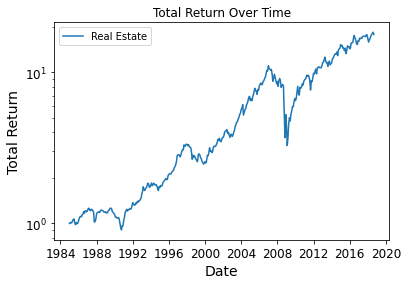

In [8]:
name = 'Real Estate'
plot_returns(all_data, name, flag='Total Return')

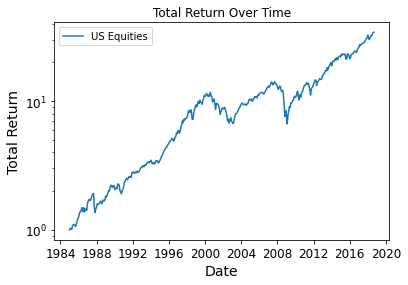

In [9]:
name = 'US Equities'
plot_returns(all_data, name, flag='Total Return')

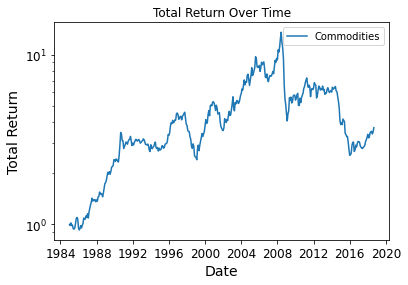

In [10]:
name = 'Commodities'
plot_returns(all_data, name, flag='Total Return')

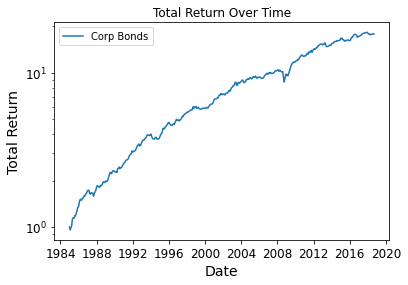

In [11]:
name = 'Corp Bonds'
plot_returns(all_data, name, flag='Total Return')

In [12]:
all_data.sort_values('US Equities').head(5)

,Date,World Equities,US Treasuries,Bond Risk Premium,Inflation Protection,Currency Protection,US Equities,Real Estate,Commodities,Corp Bonds
33,1987-10-01,-0.145045,0.068928,-0.101626,-0.010618,-0.025647,-0.227451,-0.142819,-0.013019,0.047145
285,2008-10-01,-0.204945,-0.039976,-0.112578,-0.083037,0.024725,-0.173147,-0.312202,-0.295256,-0.068198
286,2008-11-01,-0.111894,0.154699,-0.249246,-0.044064,-0.010747,-0.162932,-0.337308,-0.175630,0.053776
289,2009-02-01,-0.126883,-0.009799,-0.021226,-0.014250,0.004337,-0.148267,-0.268897,-0.097275,-0.020985
163,1998-08-01,-0.127485,0.041625,-0.099577,-0.024030,-0.011732,-0.119207,-0.103474,-0.026712,0.004132


# OLS Regression


Building a factor module is equivalent to solving for the factor loadings.

 Ordinary Least Squares (OLS) regression is the simplest way.

OLS regression is equivalent to solving the following optimization problem

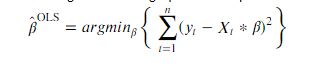
 

In our notation, n in the number of data points. In this case, OLS regression has a closed form solution.


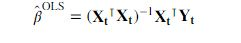

 
Where  𝐘𝐭  is the vector representation of  𝑦𝑡 , and  𝐗𝐭  is the matrix representation of  𝑋𝑡 
𝛽̂ is the factor loadings.They represent the effect on the dependent variable caused by movement in the underlying factor.

In [13]:
def display_factor_loadings(intercept, coefs, factorNames, options):
    '''display_factor_loadings takes an intercept, coefs, factorNames and options dict, and prints the factor loadings in a readable way
    INPUTS:
        intercept: float, intercept value
        coefs: np array, coeficients from pandas df
        factorNames: list, names of the factors
        options: dict, should contain at least one key, nameOfReg
            nameOfReg: string, name for the regression
    Outputs:
        output is printed
    '''
    loadings = np.insert(coefs, 0, intercept)
    if('nameOfReg' not in options.keys()):
        name = 'No Name'
    else:
        name = options['nameOfReg']
    out = pd.DataFrame(loadings, columns=[name])
    out = out.transpose()
    fullNames = ['Intercept'] + factorNames
    out.columns = fullNames
    return(out)

In [14]:
def create_options():
    '''create standard options dictionary to be used as input to regression functions'''
    options = dict()
    options['timeperiod'] = 'all'
    options['date'] = 'Date'
    options['returnModel'] = False
    options['printLoadings'] = True
    return options

In [15]:
def num_to_month(month):
    #num to month returns the name of the month, input is an integer
    if (month==1):
        return 'January'
    if (month==2):
        return 'Febuary'
    if (month==3):
        return 'March'
    if (month==4):
        return 'April'
    if (month==5):
        return 'May'
    if (month==6):
        return 'June'
    if (month==7):
        return 'July'
    if (month==8):
        return 'August'
    if (month==9):
        return 'September'
    if (month==10):
        return 'October'
    if (month==11):
        return 'November'
    if (month==12):
        return 'December'

In [16]:
def print_timeperiod(data, dependentVar, options):
    '''print_timeperiod takes a a dependent varaible and a options dictionary, prints out the time period
    INPUTS:
        data: pandas df, df with the data
        dependentVar: string, name of dependent variable
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
    OUTPUTS:
        printed stuff
    '''
    print ('Dependent Variable is ' + dependentVar)
    if(options['timeperiod'] == 'all'):
        sortedValues = data.sort_values(options['date'])[options['date']].reset_index(drop=True)
        n = sortedValues.shape[0]
        beginDate = sortedValues[0]
        endDate = sortedValues[n-1]
        print ('Time period is between ' + num_to_month(beginDate.month) +  ' ' + str(beginDate.year) + ' to ' + num_to_month(endDate.month) +  ' ' + str(endDate.year) + ' inclusive   ')        
    else:
        print ('Time period is ' + options['timeperiod'])

In [17]:
def linear_regression(data, dependentVar, factorNames, options):
    '''linear_regression takes in a dataset and returns the factor loadings using least squares regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #first filter down to the time period
    if(options['timeperiod'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['timeperiod'])

    #perform linear regression
    linReg = LinearRegression(fit_intercept=True)
    linReg.fit(newData[factorNames], newData[dependentVar])
    
    if (options['printLoadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        # Now print the factor loadings
        out=display_factor_loadings(linReg.intercept_, linReg.coef_, factorNames, options)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.max_rows', None)
        print(out)
        df_m=pd.DataFrame({'features':factorNames,'coeff':linReg.coef_})
        df_m=df_m.sort_values(by=['coeff'])
        df_m.plot(x='features',y='coeff',kind='bar',figsize=(15,6))
        plt.title('dependence factors of US Equities against different FACTOR LOADINGS')
        plt.xlabel('FACTOR LOADINGS')
        plt.ylabel('coeff for US Equities')
        plt.show();

    if(options['returnModel']):
        return linReg

In [18]:
factorName = ['World Equities','US Treasuries','Bond Risk Premium','Inflation Protection','Currency Protection']
assetName = ['US Equities','Real Estate','Commodities','Corp Bonds']

In [19]:
# Linear Regression (OLS)
Factors = all_data[factorName].values
Assets = all_data[assetName].values

Asset_RE = Assets[:,0]
Factors_ones = np.concatenate((np.ones((all_data.shape[0],1)),Factors),axis=1)
theory_beta = np.linalg.inv(Factors_ones.T.dot(Factors_ones)).dot(Factors_ones.T).dot(Asset_RE)
print('Dependent variable is US Equities')
opt = dict()
opt['nameOfReg'] = 'theory_beta'
out=display_factor_loadings(theory_beta[0], theory_beta[1:], factorName, opt)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(out)

Dependent variable is US Equities
             Intercept  World Equities  US Treasuries  Bond Risk Premium  \
theory_beta   0.000049        0.536876       0.579876            0.61014   

             Inflation Protection  Currency Protection  
theory_beta              0.083233             0.625217  


Dependent Variable is US Equities
Time period is between January 1985 to September 2018 inclusive   
                 Intercept  World Equities  US Treasuries  Bond Risk Premium  \
sikit-learn OLS   0.000049        0.536876       0.579876            0.61014   

                 Inflation Protection  Currency Protection  
sikit-learn OLS              0.083233             0.625217  


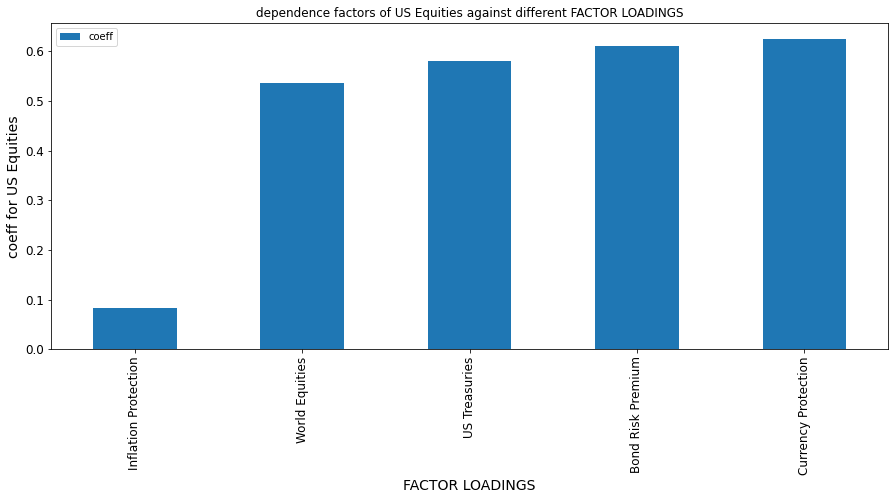

In [20]:
#Linear Regression via Scikit-learn
from sklearn.linear_model import LinearRegression
options = create_options()
options['nameOfReg'] = 'sikit-learn OLS'
linear_regression(all_data, 'US Equities',factorName, options)

In [21]:
# Linear Regression (OLS)
Factors = all_data[factorName].values
Assets = all_data[assetName].values

Asset_RE = Assets[:,1]
Factors_ones = np.concatenate((np.ones((all_data.shape[0],1)),Factors),axis=1)
theory_beta = np.linalg.inv(Factors_ones.T.dot(Factors_ones)).dot(Factors_ones.T).dot(Asset_RE)
print('Dependent variable is Real Estate')
#print(theory_beta)
opt = dict()
opt['nameOfReg'] = 'theory_beta'
#print(theory_beta[0])
out=display_factor_loadings(theory_beta[0], theory_beta[1:], factorName, opt)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(out)

Dependent variable is Real Estate
             Intercept  World Equities  US Treasuries  Bond Risk Premium  \
theory_beta  -0.003587        0.310261       1.212508           1.054238   

             Inflation Protection  Currency Protection  
theory_beta              0.287919              0.36184  


Dependent Variable is Real Estate
Time period is between January 1985 to September 2018 inclusive   
                 Intercept  World Equities  US Treasuries  Bond Risk Premium  \
sikit-learn OLS  -0.003587        0.310261       1.212508           1.054238   

                 Inflation Protection  Currency Protection  
sikit-learn OLS              0.287919              0.36184  


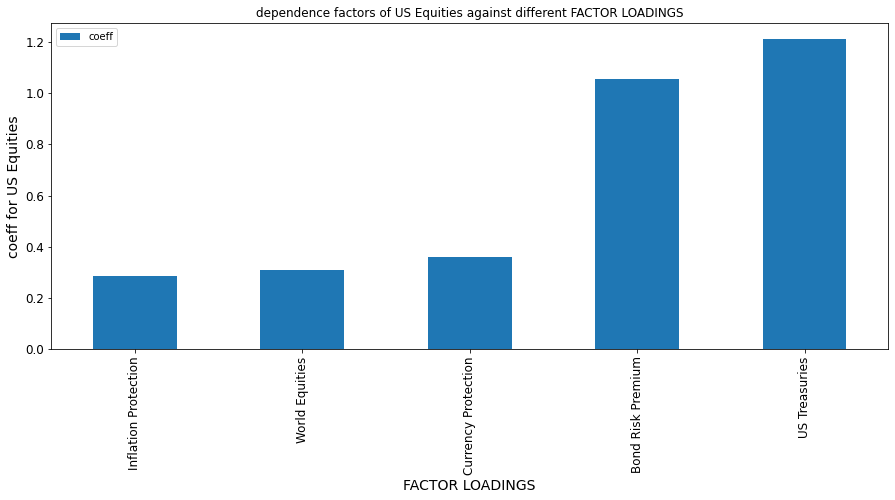

In [22]:
from sklearn.linear_model import LinearRegression
options = create_options()
options['nameOfReg'] = 'sikit-learn OLS'
linear_regression(all_data, 'Real Estate',factorName, options)

In [23]:
# Linear Regression (OLS)
Factors = all_data[factorName].values
Assets = all_data[assetName].values
Asset_RE = Assets[:,2]
Factors_ones = np.concatenate((np.ones((all_data.shape[0],1)),Factors),axis=1)
theory_beta = np.linalg.inv(Factors_ones.T.dot(Factors_ones)).dot(Factors_ones.T).dot(Asset_RE)
print('Dependent variable is Commodities')
opt = dict()
opt['nameOfReg'] = 'theory_beta'
#print(theory_beta[0])
out=display_factor_loadings(theory_beta[0], theory_beta[1:], factorName, opt)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(out)

Dependent variable is Commodities
             Intercept  World Equities  US Treasuries  Bond Risk Premium  \
theory_beta   0.004641        0.255708      -0.095741           0.133667   

             Inflation Protection  Currency Protection  
theory_beta              0.583607            -0.884024  


Dependent Variable is Commodities
Time period is between January 1985 to September 2018 inclusive   
                 Intercept  World Equities  US Treasuries  Bond Risk Premium  \
sikit-learn OLS   0.004641        0.255708      -0.095741           0.133667   

                 Inflation Protection  Currency Protection  
sikit-learn OLS              0.583607            -0.884024  


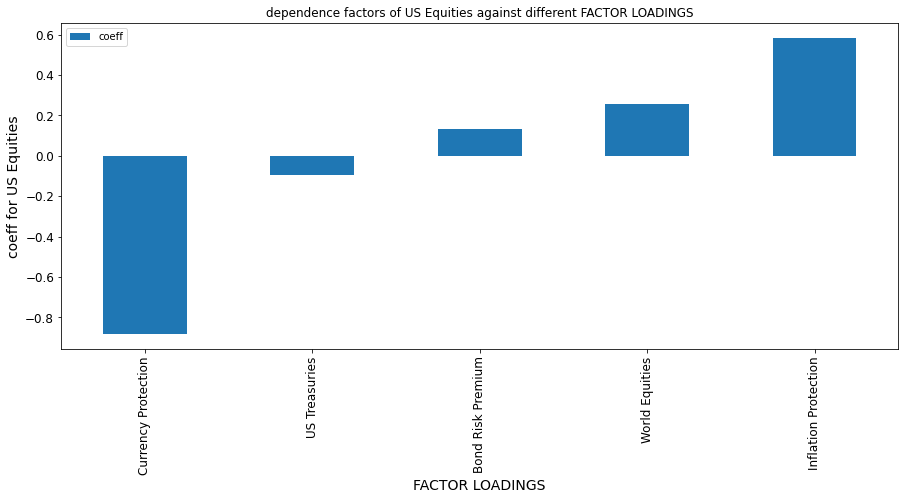

In [24]:
from sklearn.linear_model import LinearRegression
options = create_options()
options['nameOfReg'] = 'sikit-learn OLS'
linear_regression(all_data, 'Commodities',factorName, options)

In [25]:
# Linear Regression (OLS)
Factors = all_data[factorName].values
Assets = all_data[assetName].values
Asset_RE = Assets[:,3]
Factors_ones = np.concatenate((np.ones((all_data.shape[0],1)),Factors),axis=1)
theory_beta = np.linalg.inv(Factors_ones.T.dot(Factors_ones)).dot(Factors_ones.T).dot(Asset_RE)
print('Dependent variable is Corp Bonds')
opt = dict()
opt['nameOfReg'] = 'theory_beta'
#print(theory_beta[0])
out=display_factor_loadings(theory_beta[0], theory_beta[1:], factorName, opt)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(out)

Dependent variable is Corp Bonds
             Intercept  World Equities  US Treasuries  Bond Risk Premium  \
theory_beta   0.001694        0.004594       0.805775            0.35977   

             Inflation Protection  Currency Protection  
theory_beta              0.022835            -0.148184  


Dependent Variable is Corp Bonds
Time period is between January 1985 to September 2018 inclusive   
                 Intercept  World Equities  US Treasuries  Bond Risk Premium  \
sikit-learn OLS   0.001694        0.004594       0.805775            0.35977   

                 Inflation Protection  Currency Protection  
sikit-learn OLS              0.022835            -0.148184  


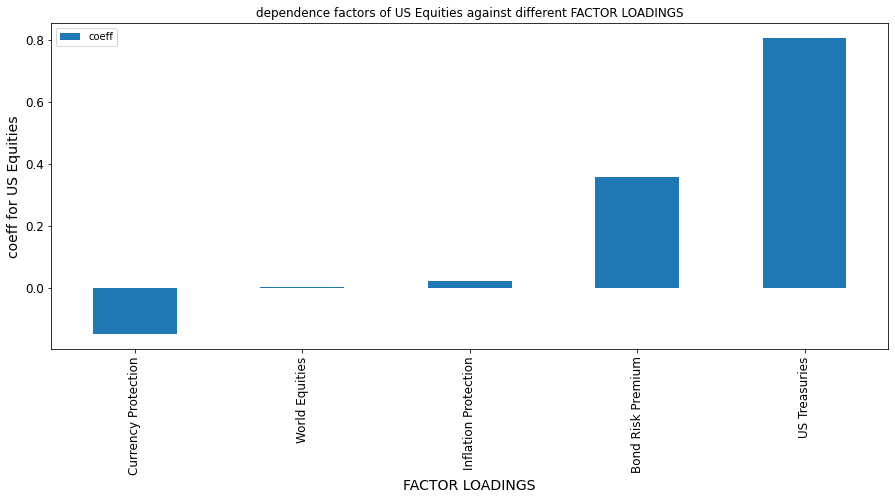

In [26]:
from sklearn.linear_model import LinearRegression
options = create_options()
options['nameOfReg'] = 'sikit-learn OLS'
linear_regression(all_data, 'Corp Bonds',factorName, options)

# OLS Drawbacks 
Firstly OLS has no mechanism to filter out noise variables. 

Secondly, it assumes that factor loadings are constant over time. 

we will  have many noise variables that need to be removed.

we will know factor loadings are highly dependent on the time period.

# DEMONSTRAING FIRST OLS DRAWBACK:

we will introduce a noise variable positivly correlated with the World Equities factor. Then we re-run the OLS regression. The OLS regression chosses to average the two signals, changing the loading on the World Equity factor.

In [27]:
#Calculate a noise variable
std = all_data['World Equities'].std()*(2)
nPeriods = all_data.shape[0]
np.random.seed(1245)
noise = np.random.normal(loc=0, size=(nPeriods))
noise = np.reshape(std*noise + np.array(all_data['World Equities']), (nPeriods,1))
all_data['Noise'] = noise
factorNameWithNoise = factorName + ['Noise']

Dependent Variable is Real Estate
Time period is between January 1985 to September 2018 inclusive   
                Intercept  World Equities  US Treasuries  Bond Risk Premium  \
OLS with Noise  -0.003654        0.323065       1.214039           1.054216   

                Inflation Protection  Currency Protection     Noise  
OLS with Noise              0.283488             0.361987 -0.010582  


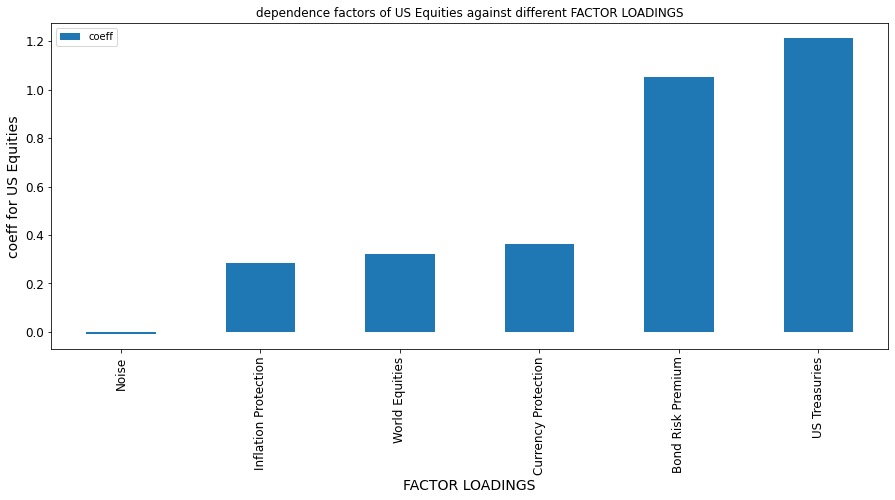

In [28]:
options = create_options()
options['nameOfReg'] = 'OLS with Noise'
linear_regression(all_data, 'Real Estate', factorNameWithNoise, options)

Dependent Variable is Real Estate
Time period is between January 1985 to September 2018 inclusive   
               Intercept  World Equities  US Treasuries  Bond Risk Premium  \
OLS full data  -0.003587        0.310261       1.212508           1.054238   

               Inflation Protection  Currency Protection  
OLS full data              0.287919              0.36184  


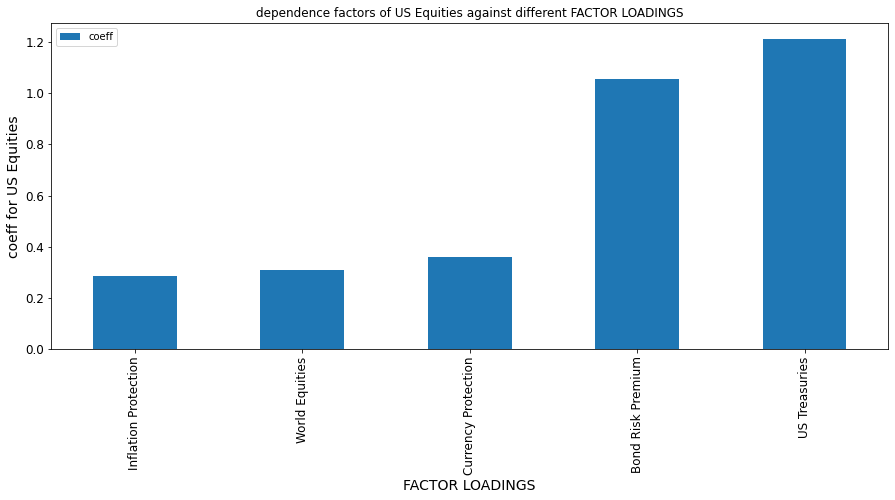

In [29]:
options['nameOfReg'] = 'OLS full data'
linear_regression(all_data, 'Real Estate',factorName, options)

# DEMONSTRAING SECOND OLS DRAWBACK:

 we will filter our data into two different regimes. 
 
 The first regime "normal", will be months where US Equities had a positive monthly return. 
 
 The second regime, "crash" will be months where US Equities had a negative return. 
 
we can see different factor loadings for Crash periods and Normal Periods

Dependent Variable is Real Estate
Time period is between January 1985 to September 2018 inclusive   
            Intercept  World Equities  US Treasuries  Bond Risk Premium  \
OLS Normal    0.00348         0.15022        1.30286           1.100558   

            Inflation Protection  Currency Protection  
OLS Normal              0.210193              0.05183  


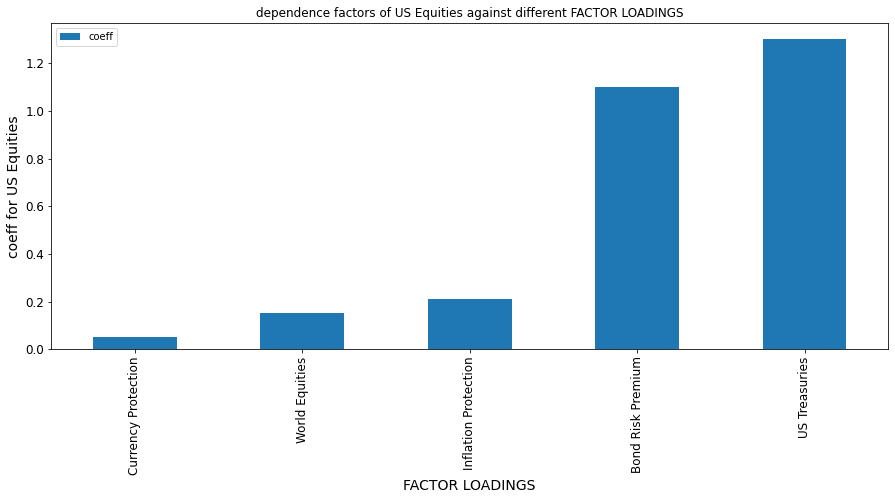

In [30]:
normalData = all_data[all_data['US Equities'] > 0].copy()
options['nameOfReg'] = 'OLS Normal'
linear_regression(normalData, 'Real Estate',factorName, options)

Dependent Variable is Real Estate
Time period is between March 1985 to June 2018 inclusive   
           Intercept  World Equities  US Treasuries  Bond Risk Premium  \
OLS Crash  -0.011274        0.365824       0.959781           0.792532   

           Inflation Protection  Currency Protection  
OLS Crash              0.540801             0.588727  


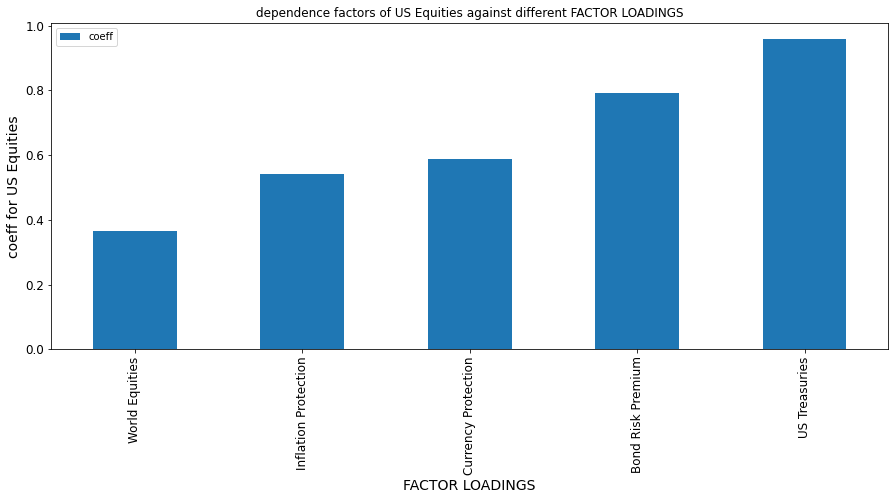

In [31]:
crashData = all_data[all_data['US Equities'] <= 0].copy()
options['nameOfReg'] = 'OLS Crash'
linear_regression(crashData, 'Real Estate',factorName, options)

In [32]:
!jupyter nbconvert Factomodels_OLS_REGRESSION.ipynb

[NbConvertApp] WARNING | pattern u'Factomodels_OLS_REGRESSION.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--in